In [1]:
#Import modules and download the cats and dogs dataset.
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile


data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()


In [2]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


### Create some folders that will store the training and test data.

- There are a training folder and a testing folder.
- Each of these have a subfolder for cats and another subfolder for dogs.

In [3]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

### Split data into training and test sets
- The following code put first checks if an image file is empty (zero length)
- Of the files that are not empty, it puts 90% of the data into the training set, and 10% into the test set.

In [4]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)



666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
# Check that the training and test sets are the expected lengths.
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images 12498
Number of training dog images 12500
Number of testing cat images 4293
Number of testing dog images 4306


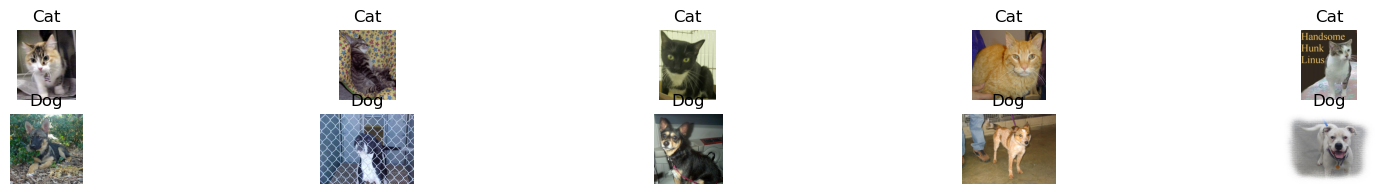

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load and show 10 random images from the training directories
def show_examples(cats_dir, dogs_dir, num_examples=10):
    # Get all file names from both the cat and dog directories
    cat_images = os.listdir(cats_dir)
    dog_images = os.listdir(dogs_dir)

    # Randomly sample from both sets
    cat_samples = random.sample(cat_images, num_examples // 2)
    dog_samples = random.sample(dog_images, num_examples // 2)

    # Prepare the figure with a row of subplots
    plt.figure(figsize=(20, 2))

    # Display the cat images
    for i, img_name in enumerate(cat_samples):
        img_path = os.path.join(cats_dir, img_name)
        img = mpimg.imread(img_path)
        ax = plt.subplot(2, num_examples // 2, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Cat')

    # Display the dog images
    for i, img_name in enumerate(dog_samples):
        img_path = os.path.join(dogs_dir, img_name)
        img = mpimg.imread(img_path)
        ax = plt.subplot(2, num_examples // 2, num_examples // 2 + i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Dog')

    plt.show()

# Display 10 examples with labels from the training data
show_examples(TRAINING_CATS_DIR, TRAINING_DOGS_DIR)


### Data augmentation
Here, I use the ImageDataGenerator to perform data augmentation.

- Things like rotating and flipping the existing images allows to generate training data that is more varied, and can help the model generalize better during training.
- I also use the data generator to apply data augmentation to the validation set.

In [7]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 24996 images belonging to 2 classes.
Found 8599 images belonging to 2 classes.


### Get and prepare the model
Here I use the InceptionV3 model.

- I load the pre-trained weights of the model.
- I also freeze the existing layers so that they aren't trained on my downstream task with the cats and dogs data.
- I also get a reference to the last layer, 'mixed7' because I add some layers after this last layer.

In [8]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output



last layer output shape:  (None, 7, 7, 768)


### Add layers
Add some layers that I train on the cats and dogs data.

- Flatten: This take the output of the last_layer and flatten it to a vector.
- Dense: I add a dense layer with a relu activation.
- Dense: After that, add a dense layer with a sigmoid activation. The sigmoid scales the output to range from 0 to 1, and allow to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)


### Train the model
Compile the model, and then train it on the test data using model.fit

- This project was originally designed with 20 epochs. For the sake of time, I use fewer epochs (5).

In [10]:
# compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=5,
            verbose=1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 43/250 ━━━━━━━━━━━━━━━━━━━━ 1:21 396ms/step - acc: 0.7505 - loss: 0.8922

/opt/anaconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 527ms/step - acc: 0.9107 - loss: 0.2202 - val_acc: 0.9567 - val_loss: 0.1033
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 547ms/step - acc: 0.9400 - loss: 0.1400 - val_acc: 0.9767 - val_loss: 0.0587
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - acc: 0.9439 - loss: 0.1328 - val_acc: 0.9759 - val_loss: 0.0592
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - acc: 0.9465 - loss: 0.1265 - val_acc: 0.9776 - val_loss: 0.0573
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 572ms/step - acc: 0.9513 - loss: 0.1168 - val_acc: 0.9771 - val_loss: 0.0591


### Visualize the training and validation accuracy
show how the training and validation accuracy change with each epoch on an x-y plot.

In [11]:
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

<Figure size 640x480 with 0 Axes>

### Predict on a test image
- I add one image and have the model predict whether it's a dog or a cat.
- I also show the test image with predicted class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


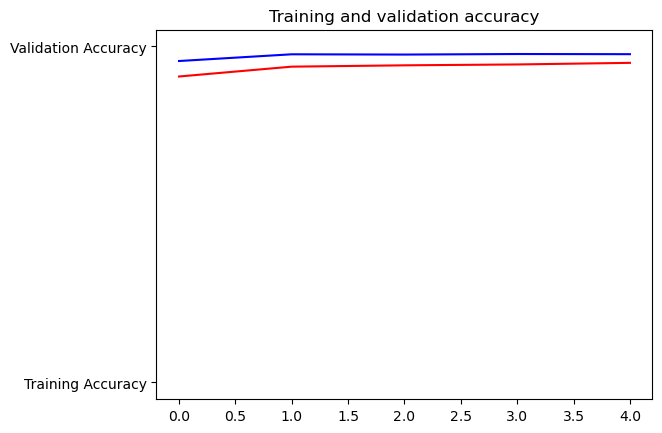

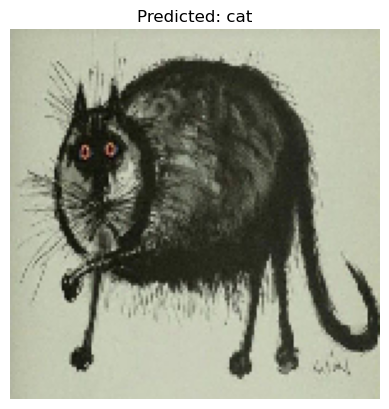

The image is predicted to be a cat.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

image_path = './cat.jpeg' 

# Load and preprocess the image
img = load_img(image_path, target_size=(150, 150))  # Resize the image to match the model input
x = img_to_array(img)  # Convert image to numpy array
x /= 255  # Normalize the image
x = np.expand_dims(x, axis=0)  # Expand dimensions to match the model's expected input

# Predict the class
image_tensor = np.vstack([x])
classes = model.predict(image_tensor)

# Class prediction
class_label = "dog" if classes[0] > 0.5 else "cat"

# Plot the image
plt.imshow(img)
plt.title(f"Predicted: {class_label}")  # Display the predicted class as title
plt.axis('off') 
plt.show()

# Output the result
print(f"The image is predicted to be a {class_label}.")
